In [20]:
import os
import random
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from jinja2 import Template
import matplotlib.pyplot as plt

In [26]:
class RTLDatasetGenerator:
    """
    A class to generate synthetic RTL designs with known combinational depth
    for training and evaluating logic depth prediction models.
    """
    
    def __init__(self, output_dir="rtl_dataset"):
        """
        Initialize the generator
        
        Args:
            output_dir: Directory to store generated RTL files and metadata
        """
        self.output_dir = output_dir
        self.rtl_dir = os.path.join(output_dir, "rtl")
        self.synthesis_dir = os.path.join(output_dir, "synthesis")
        self.metadata_path = os.path.join(output_dir, "metadata.json")
        
        # Create directories
        os.makedirs(self.rtl_dir, exist_ok=True)
        os.makedirs(self.synthesis_dir, exist_ok=True)
        
        # Templates for different complexity levels
        self.templates = self._initialize_templates()
        
        # Initialize metadata
        self.metadata = {
            "designs": {},
            "total_designs": 0,
            "creation_timestamp": pd.Timestamp.now().isoformat()
        }
    
    def _initialize_templates(self):
        """
        Initialize Jinja2 templates for RTL generation
        
        Returns:
            dict: Dictionary of templates for different complexity levels
        """
        templates = {}
        
        # Simple combinational circuit (ALU-like)
        templates["simple_alu"] = Template("""
module simple_alu_{{ design_id }}(
    input [{{ input_width-1 }}:0] a, b,
    input [{{ op_width-1 }}:0] op,
    output reg [{{ output_width-1 }}:0] {{ result_signal }}
);

    always @(*) begin
        case(op)
            {% for i in range(num_ops) %}
            {{ op_width }}'d{{ i }}: {{ result_signal }} = {{ op_expressions[i] }};
            {% endfor %}
            default: {{ result_signal }} = {{ default_expression }};
        endcase
    end

endmodule
        """)
        
        # Counter with combinational logic
        templates["counter_with_logic"] = Template("""
module counter_with_logic_{{ design_id }}(
    input clk,
    input rst_n,
    input enable,
    input [{{ input_width-1 }}:0] data_in,
    input [{{ op_width-1 }}:0] mode,
    output reg [{{ output_width-1 }}:0] {{ result_signal }}
);

    reg [{{ counter_width-1 }}:0] counter;
    wire [{{ output_width-1 }}:0] intermediate;
    
    // Counter logic
    always @(posedge clk or negedge rst_n) begin
        if (!rst_n)
            counter <= {{ counter_width }}'d0;
        else if (enable)
            counter <= counter + {{ counter_width }}'d1;
    end
    
    // Combinational logic
    {% for i in range(num_stages) %}
    {% if i == 0 %}
    wire [{{ output_width-1 }}:0] stage{{ i }} = {{ stage0_expr }};
    {% else %}
    wire [{{ output_width-1 }}:0] stage{{ i }} = {{ stage_expressions[i-1] }};
    {% endif %}
    {% endfor %}
    
    always @(*) begin
        case(mode)
            {% for i in range(num_modes) %}
            {{ op_width }}'d{{ i }}: {{ result_signal }} = {{ mode_expressions[i] }};
            {% endfor %}
            default: {{ result_signal }} = stage{{ num_stages-1 }};
        endcase
    end

endmodule
        """)
        
        # Pipeline with combinational stages
        templates["pipeline"] = Template("""
module pipeline_{{ design_id }}(
    input clk,
    input rst_n,
    input [{{ input_width-1 }}:0] data_in,
    input [{{ op_width-1 }}:0] control,
    output reg [{{ output_width-1 }}:0] {{ result_signal }}
);

    // Pipeline registers
    {% for i in range(num_stages) %}
    reg [{{ output_width-1 }}:0] stage{{ i }}_reg;
    wire [{{ output_width-1 }}:0] stage{{ i }}_next;
    {% endfor %}
    
    // Combinational logic for each stage
    {% for i in range(num_stages) %}
    {% if i == 0 %}
    assign stage{{ i }}_next = {{ stage_expressions[i] }};
    {% else %}
    assign stage{{ i }}_next = {{ stage_expressions[i] }};
    {% endif %}
    {% endfor %}
    
    // Pipeline registers update
    always @(posedge clk or negedge rst_n) begin
        if (!rst_n) begin
            {% for i in range(num_stages) %}
            stage{{ i }}_reg <= {{ output_width }}'d0;
            {% endfor %}
        end else begin
            {% for i in range(num_stages) %}
            {% if i == 0 %}
            stage{{ i }}_reg <= stage{{ i }}_next;
            {% else %}
            stage{{ i }}_reg <= stage{{ i }}_next;
            {% endif %}
            {% endfor %}
        end
    end
    
    // Output selection based on control
    always @(*) begin
        case(control)
            {% for i in range(num_stages) %}
            {{ op_width }}'d{{ i }}: {{ result_signal }} = stage{{ i }}_reg;
            {% endfor %}
            default: {{ result_signal }} = stage{{ num_stages-1 }}_reg;
        endcase
    end

endmodule
        """)
        
        # Complex datapath with nested operations
        templates["complex_datapath"] = Template("""
module complex_datapath_{{ design_id }}(
    input clk,
    input rst_n,
    input [{{ input_width-1 }}:0] a, b, c, d,
    input [{{ op_width-1 }}:0] mode,
    output reg [{{ output_width-1 }}:0] {{ result_signal }}
);

    // Internal signals
    {% for i in range(num_internal_signals) %}
    reg [{{ output_width-1 }}:0] internal{{ i }};
    {% endfor %}
    
    // Temporary signals for complex operations
    {% for i in range(num_temp_signals) %}
    reg [{{ output_width-1 }}:0] temp{{ i }};
    {% endfor %}
    
    // Combinational logic
    always @(*) begin
        // First level operations
        {% for i in range(num_level1_ops) %}
        {{ level1_ops[i] }}
        {% endfor %}
        
        // Second level operations depending on mode
        case(mode[{{ op_width-1 }}:{{ op_width//2 }}])
            {% for i in range(num_level2_cases) %}
            {{ op_width//2 }}'d{{ i }}: begin
                {{ level2_ops[i] }}
            end
            {% endfor %}
            default: begin
                {{ default_level2 }}
            end
        endcase
        
        // Final operations depending on mode
        case(mode[{{ op_width//2-1 }}:0])
            {% for i in range(num_level3_cases) %}
            {{ op_width//2 }}'d{{ i }}: begin
                {{ level3_ops[i] }}
            end
            {% endfor %}
            default: begin
                {{ default_level3 }}
            end
        endcase
    end

endmodule
        """)
        
        # Custom processor datapath
        templates["processor_datapath"] = Template("""
module processor_datapath_{{ design_id }}(
    input clk,
    input rst_n,
    input [{{ instr_width-1 }}:0] instruction,
    input [{{ input_width-1 }}:0] operand_a, operand_b,
    output reg [{{ output_width-1 }}:0] {{ result_signal }}
);

    // Decode instruction
    wire [{{ op_width-1 }}:0] opcode = instruction[{{ instr_width-1 }}:{{ instr_width-op_width }}];
    wire [{{ addr_width-1 }}:0] addr = instruction[{{ addr_width-1 }}:0];
    
    // Register file
    reg [{{ output_width-1 }}:0] registers [{{ num_registers-1 }}:0];
    
    // ALU inputs
    reg [{{ input_width-1 }}:0] alu_a, alu_b;
    wire [{{ output_width-1 }}:0] alu_result;
    
    // ALU operation
    always @(*) begin
        case(opcode)
            {% for i in range(num_ops) %}
            {{ op_width }}'d{{ i }}: alu_result = {{ alu_ops[i] }};
            {% endfor %}
            default: alu_result = alu_a;
        endcase
    end
    
    // Datapath control
    always @(*) begin
        // Default assignments
        alu_a = operand_a;
        alu_b = operand_b;
        
        // Source selection based on instruction bits
        if (instruction[{{ addr_width+1 }}]) begin
            alu_a = registers[instruction[{{ addr_width-1 }}:{{ addr_width//2 }}]];
        end
        
        if (instruction[{{ addr_width }}]) begin
            alu_b = registers[instruction[{{ addr_width//2-1 }}:0]];
        end
        
        // Result signal assignment
        {{ result_signal }} = alu_result;
    end
    
    // Register update logic
    always @(posedge clk or negedge rst_n) begin
        if (!rst_n) begin
            {% for i in range(num_registers) %}
            registers[{{ i }}] <= {{ output_width }}'d0;
            {% endfor %}
        end else if (instruction[{{ instr_width-op_width-1 }}]) begin
            registers[addr] <= alu_result;
        end
    end

endmodule
        """)
        
        return templates
    
    def _generate_random_expression(self, signal_names, width, depth=1, max_depth=3):
        """
        Generate a random expression for RTL
        
        Args:
            signal_names: List of signal names to use
            width: Bit width of the expression
            depth: Current depth of the expression
            max_depth: Maximum depth to allow
            
        Returns:
            tuple: (expression_string, logical_depth)
        """
        # Operations with their complexity weights
        operations = [
            (lambda a, b: f"({a} & {b})", 1),           # AND
            (lambda a, b: f"({a} | {b})", 1),           # OR
            (lambda a, b: f"({a} ^ {b})", 2),           # XOR
            (lambda a, b: f"(~{a})", 1),                # NOT
            (lambda a, b: f"({a} + {b})", 3),           # ADD
            (lambda a, b: f"({a} - {b})", 3),           # SUB
            (lambda a, b: f"({a} * {b})", 5),           # MUL
            (lambda a, b: f"({a} << {random.randint(1, width//4)})", 2),  # SHIFT LEFT
            (lambda a, b: f"({a} >> {random.randint(1, width//4)})", 2),  # SHIFT RIGHT
            (lambda a, b: f"({a} ? {b} : {random.randint(0, 2**width-1)})", 3),  # TERNARY
        ]
        
        # Terminal expressions (leaf nodes)
        terminals = [
            *signal_names,
            *[f"{width}'d{random.randint(0, 2**width-1)}" for _ in range(3)]
        ]
        
        # If we've reached max depth or randomly decide to stop, return a terminal
        if depth >= max_depth or (depth > 1 and random.random() < 0.3):
            term = random.choice(terminals)
            # Terminals have depth 0, except for signals which have depth 1
            return term, 1 if term in signal_names else 0
        
        # Choose an operation
        op_func, op_depth = random.choice(operations)
        
        # For unary operations
        if op_func.__code__.co_argcount < 2:
            sub_expr, sub_depth = self._generate_random_expression(
                signal_names, width, depth + 1, max_depth
            )
            return op_func(sub_expr, None), op_depth + sub_depth
        
        # For binary operations
        left_expr, left_depth = self._generate_random_expression(
            signal_names, width, depth + 1, max_depth
        )
        right_expr, right_depth = self._generate_random_expression(
            signal_names, width, depth + 1, max_depth
        )
        
        return op_func(left_expr, right_expr), op_depth + max(left_depth, right_depth)
    
    def _calc_expression_depth(self, expr):
        """
        Estimate the logical depth of an expression
        This is a simplified version - in practice, synthesis tools do more optimizations
        
        Args:
            expr: Expression string
            
        Returns:
            int: Estimated logical depth
        """
        # Count basic operations that contribute to depth
        operations = {
            '&': 1,    # AND
            '|': 1,    # OR
            '^': 2,    # XOR
            '~': 1,    # NOT
            '+': 3,    # ADD
            '-': 3,    # SUB
            '*': 5,    # MUL
            '<<': 2,   # SHIFT LEFT
            '>>': 2,   # SHIFT RIGHT
            '?': 3,    # TERNARY
        }
        
        # Count each operation and calculate depth
        depth = 0
        for op, weight in operations.items():
            depth += expr.count(op) * weight
        
        # Add complexity for nested expressions (parentheses)
        nesting = 0
        max_nesting = 0
        for char in expr:
            if char == '(':
                nesting += 1
                max_nesting = max(max_nesting, nesting)
            elif char == ')':
                nesting -= 1
        
        # Add nesting factor
        depth += max_nesting
        
        return max(1, depth)  # Minimum depth is 1

    def generate_simple_alu(self, design_id, complexity=1):
        """
        Generate a simple ALU-like design
        
        Args:
            design_id: Unique ID for the design
            complexity: Complexity level (1-5)
            
        Returns:
            tuple: (rtl_code, result_signal_name, expected_depth)
        """
        # Scale parameters based on complexity
        input_width = 4 + complexity * 2
        output_width = input_width
        op_width = 2 + (complexity // 2)
        num_ops = 2**op_width if complexity < 3 else random.randint(2, 2**op_width)
        
        # Generate result signal name
        result_signal = f"result_{design_id}"
        
        # Generate operation expressions
        signal_names = ["a", "b"]
        op_expressions = []
        expected_depths = []
        
        for _ in range(num_ops):
            expr, depth = self._generate_random_expression(
                signal_names, 
                output_width, 
                max_depth=1 + complexity
            )
            op_expressions.append(expr)
            expected_depths.append(depth)
        
        # Default expression
        default_expression, default_depth = self._generate_random_expression(
            signal_names, output_width, max_depth=1
        )
        expected_depths.append(default_depth)
        
        # Render template
        rtl_code = self.templates["simple_alu"].render(
            design_id=design_id,
            input_width=input_width,
            output_width=output_width,
            op_width=op_width,
            num_ops=num_ops,
            result_signal=result_signal,
            op_expressions=op_expressions,
            default_expression=default_expression
        )
        
        # Estimated depth is the maximum depth of any operation path
        estimated_depth = max(expected_depths)
        
        return rtl_code, result_signal, estimated_depth
    
    def generate_counter_with_logic(self, design_id, complexity=1):
        """
        Generate a counter with combinational logic
        
        Args:
            design_id: Unique ID for the design
            complexity: Complexity level (1-5)
            
        Returns:
            tuple: (rtl_code, result_signal_name, expected_depth)
        """
        # Scale parameters based on complexity
        input_width = 4 + complexity * 2
        output_width = input_width
        counter_width = input_width
        op_width = 2 + (complexity // 2)
        num_stages = 1 + complexity
        num_modes = 2**op_width if complexity < 3 else random.randint(2, 2**op_width)
        
        # Generate result signal name
        result_signal = f"result_{design_id}"
        
        # Generate stage expressions
        signal_names = ["data_in", "counter"]
        stage0_expr = f"data_in ^ counter"  # Simple XOR for first stage
        stage_expressions = []
        stage_depths = [2]  # Depth for first stage
        
        for i in range(1, num_stages):
            prev_stage = f"stage{i-1}"
            signal_names.append(prev_stage)
            expr, depth = self._generate_random_expression(
                signal_names, 
                output_width, 
                max_depth=1 + (complexity // 2)
            )
            stage_expressions.append(expr)
            stage_depths.append(depth + stage_depths[-1])  # Accumulate depth
        
        # Generate mode expressions
        mode_expressions = []
        mode_depths = []
        
        for _ in range(num_modes):
            # Randomly select a stage output
            stage_idx = random.randint(0, num_stages - 1)
            stage_name = f"stage{stage_idx}"
            
            # Generate expression based on that stage
            expr, additional_depth = self._generate_random_expression(
                [stage_name], 
                output_width,
                max_depth=1 + (complexity // 2)
            )
            mode_expressions.append(expr)
            mode_depths.append(stage_depths[stage_idx] + additional_depth)
        
        # Render template
        rtl_code = self.templates["counter_with_logic"].render(
            design_id=design_id,
            input_width=input_width,
            output_width=output_width,
            counter_width=counter_width,
            op_width=op_width,
            num_stages=num_stages,
            num_modes=num_modes,
            result_signal=result_signal,
            stage0_expr=stage0_expr,
            stage_expressions=stage_expressions,
            mode_expressions=mode_expressions
        )
        
        # Estimated depth is the maximum depth of any operation path
        estimated_depth = max(mode_depths)
        
        return rtl_code, result_signal, estimated_depth
    
    def generate_pipeline(self, design_id, complexity=1):
        """
        Generate a pipeline with combinational stages
        
        Args:
            design_id: Unique ID for the design
            complexity: Complexity level (1-5)
            
        Returns:
            tuple: (rtl_code, result_signal_name, expected_depth)
        """
        # Scale parameters based on complexity
        input_width = 4 + complexity * 2
        output_width = input_width
        op_width = 2 + (complexity // 2)
        num_stages = 2 + complexity
        
        # Generate result signal name
        result_signal = f"result_{design_id}"
        
        # Generate stage expressions
        signal_names = ["data_in", "control"]
        stage_expressions = []
        stage_depths = []
        
        for i in range(num_stages):
            if i == 0:
                # First stage uses input directly
                expr, depth = self._generate_random_expression(
                    signal_names, 
                    output_width, 
                    max_depth=1 + (complexity // 2)
                )
            else:
                # Later stages use previous stage output
                prev_stage = f"stage{i-1}_reg"
                expr, additional_depth = self._generate_random_expression(
                    [prev_stage, "control"], 
                    output_width,
                    max_depth=1 + (complexity // 2)
                )
                # Pipeline registers break the combinational path
                depth = additional_depth
            
            stage_expressions.append(expr)
            stage_depths.append(depth)
        
        # Render template
        rtl_code = self.templates["pipeline"].render(
            design_id=design_id,
            input_width=input_width,
            output_width=output_width,
            op_width=op_width,
            num_stages=num_stages,
            result_signal=result_signal,
            stage_expressions=stage_expressions
        )
        
        # For pipeline, each stage has its own depth, but registers break the combinational path
        # The output mux adds 1 level of logic
        estimated_depth = max(stage_depths) + 1
        
        return rtl_code, result_signal, estimated_depth
    
    def generate_complex_datapath(self, design_id, complexity=1):
        """
        Generate a complex datapath with nested operations
        
        Args:
            design_id: Unique ID for the design
            complexity: Complexity level (1-5)
            
        Returns:
            tuple: (rtl_code, result_signal_name, expected_depth)
        """
        # Scale parameters based on complexity
        input_width = 4 + complexity * 2
        output_width = input_width
        op_width = 4 + (complexity // 2) * 2
        num_internal_signals = 2 + complexity
        num_temp_signals = 1 + complexity
        num_level1_ops = 2 + complexity
        num_level2_cases = 2**(op_width//2) if complexity < 3 else 2 + complexity
        num_level3_cases = 2**(op_width//2) if complexity < 3 else 2 + complexity
        
        # Generate result signal name
        result_signal = f"result_{design_id}"
        
        # Signal names for expressions
        signal_names = ["a", "b", "c", "d"]
        
        # Generate level 1 operations
        level1_ops = []
        level1_depths = []
        
        for i in range(num_level1_ops):
            internal_idx = i % num_internal_signals
            # Create assignment to internal signal
            expr, depth = self._generate_random_expression(
                signal_names, 
                output_width, 
                max_depth=1 + (complexity // 2)
            )
            assignment = f"internal{internal_idx} = {expr};"
            level1_ops.append(assignment)
            level1_depths.append(depth)
        
        # Add internal signals to available names
        for i in range(num_internal_signals):
            signal_names.append(f"internal{i}")
        
        # Generate level 2 operations
        level2_ops = []
        level2_depths = []
        
        for i in range(num_level2_cases):
            # Multiple operations per case
            operations = []
            case_depth = 0
            
            for j in range(random.randint(1, 3)):
                temp_idx = j % num_temp_signals
                expr, depth = self._generate_random_expression(
                    signal_names, 
                    output_width, 
                    max_depth=1 + complexity
                )
                operations.append(f"temp{temp_idx} = {expr};")
                case_depth = max(case_depth, depth)
            
            level2_ops.append("\n                ".join(operations))
            level2_depths.append(case_depth)
        
        # Add temp signals to available names
        for i in range(num_temp_signals):
            signal_names.append(f"temp{i}")
        
        # Default level 2 operations
        default_expr, default_depth = self._generate_random_expression(
            signal_names, 
            output_width, 
            max_depth=1 + (complexity // 2)
        )
        default_level2 = f"temp0 = {default_expr};"
        level2_depths.append(default_depth)
        
        # Generate level 3 operations (final result)
        level3_ops = []
        level3_depths = []
        
        for i in range(num_level3_cases):
            expr, additional_depth = self._generate_random_expression(
                signal_names, 
                output_width, 
                max_depth=1 + complexity
            )
            level3_ops.append(f"{result_signal} = {expr};")
            
            # Level 3 depth includes previous levels plus its own operations
            total_depth = max(level1_depths) + max(level2_depths) + additional_depth
            level3_depths.append(total_depth)
        
        # Default level 3 operations
        default_expr, default_depth = self._generate_random_expression(
            signal_names, 
            output_width, 
            max_depth=1 + (complexity // 2)
        )
        default_level3 = f"{result_signal} = {default_expr};"
        level3_depths.append(max(level1_depths) + max(level2_depths) + default_depth)
        
        # Render template
        rtl_code = self.templates["complex_datapath"].render(
            design_id=design_id,
            input_width=input_width,
            output_width=output_width,
            op_width=op_width,
            result_signal=result_signal,
            num_internal_signals=num_internal_signals,
            num_temp_signals=num_temp_signals,
            num_level1_ops=num_level1_ops,
            num_level2_cases=num_level2_cases,
            num_level3_cases=num_level3_cases,
            level1_ops=level1_ops,
            level2_ops=level2_ops,
            level3_ops=level3_ops,
            default_level2=default_level2,
            default_level3=default_level3
        )
        
        # Estimated depth is the maximum depth of any operation path
        estimated_depth = max(level3_depths)
        
        return rtl_code, result_signal, estimated_depth
    
    def generate_processor_datapath(self, design_id, complexity=1):
        """
        Generate a processor datapath
        
        Args:
            design_id: Unique ID for the design
            complexity: Complexity level (1-5)
            
        Returns:
            tuple: (rtl_code, result_signal_name, expected_depth)
        """
        # Scale parameters based on complexity
        input_width = 8 + complexity * 4
        output_width = input_width
        instr_width = 16 + complexity * 4
        op_width = 4 + complexity
        addr_width = 4 + complexity
        num_registers = 2**addr_width if complexity < 3 else 8 + complexity * 2
        num_ops = 2**op_width if complexity < 3 else 4 + complexity * 2
        
        # Generate result signal name
        result_signal = f"result_{design_id}"
        
        # Generate ALU operations
        signal_names = ["alu_a", "alu_b"]
        alu_ops = []
        alu_depths = []
        
        for _ in range(num_ops):
            expr, depth = self._generate_random_expression(
                signal_names, 
                output_width, 
                max_depth=1 + complexity
            )
            alu_ops.append(expr)
            alu_depths.append(depth)
        
        # Render template
        rtl_code = self.templates["processor_datapath"].render(
            design_id=design_id,
            input_width=input_width,
            output_width=output_width,
            instr_width=instr_width,
            op_width=op_width,
            addr_width=addr_width,
            num_registers=num_registers,
            num_ops=num_ops,
            result_signal=result_signal,
            alu_ops=alu_ops
        )
        
        # Depth includes ALU operations plus mux selection (typically +2)
        estimated_depth = max(alu_depths) + 2
        
        return rtl_code, result_signal, estimated_depth

    def generate_rtl_designs(self, num_designs=100, complexity_range=(1, 5)):
        """
        Generate a dataset of RTL designs with varying complexities
        
        Args:
            num_designs: Number of designs to generate
            complexity_range: Range of complexity levels (min, max)
            
        Returns:
            dict: Dictionary mapping file paths to result signal info
        """
        design_generators = [
            self.generate_simple_alu,
            self.generate_counter_with_logic,
            self.generate_pipeline,
            self.generate_complex_datapath,
            self.generate_processor_datapath
        ]
        
        design_info = {}
        
        for i in tqdm(range(num_designs), desc="Generating RTL designs"):
            # Select random generator and complexity
            generator = random.choice(design_generators)
            complexity = random.randint(complexity_range[0], complexity_range[1])
            
            # Generate design
            design_id = f"{i:04d}"
            rtl_code, result_signal, estimated_depth = generator(design_id, complexity)
            
            # Write RTL file
            generator_name = generator.__name__.replace("generate_", "")
            filename = f"{generator_name}_{design_id}.v"
            file_path = os.path.join(self.rtl_dir, filename)
            
            with open(file_path, "w") as f:
                f.write(rtl_code)
            
            # Store design info
            design_info[file_path] = {
                "result_signal": result_signal,
                "estimated_depth": estimated_depth,
                "complexity": complexity,
                "design_type": generator_name
            }
            
            # Update metadata
            self.metadata["designs"][file_path] = {
                "result_signal": result_signal,
                "estimated_depth": estimated_depth,
                "complexity": complexity,
                "design_type": generator_name,
                "synthesis_complete": False
            }
        
        self.metadata["total_designs"] = len(design_info)
        
        self.metadata["total_designs"] = len(design_info)
        
        # Save metadata
        with open(self.metadata_path, "w") as f:
            json.dump(self.metadata, f, indent=2)
        
        return design_info

    def run_synthesis(self, design_file, result_signal):
        """
        Run synthesis on a given RTL design file
        
        Args:
            design_file: Path to the RTL design file
            result_signal: Name of the result signal to analyze
            
        Returns:
            int: Actual combinational depth from synthesis
        """
        # This is a placeholder for actual synthesis
        # In practice, you would use a real synthesis tool here
        
        # Simulate synthesis by adding some randomness to the estimated depth
        estimated_depth = self.metadata["designs"][design_file]["estimated_depth"]
        actual_depth = max(1, int(estimated_depth * random.uniform(0.8, 1.2)))
        
        # Update metadata with synthesis result
        self.metadata["designs"][design_file]["actual_depth"] = actual_depth
        self.metadata["designs"][design_file]["synthesis_complete"] = True
        
        # Save updated metadata
        with open(self.metadata_path, "w") as f:
            json.dump(self.metadata, f, indent=2)
        
        return actual_depth

    def generate_dataset(self, num_designs=100, complexity_range=(1, 5)):
        """
        Generate a complete dataset with RTL designs and synthesis results
        
        Args:
            num_designs: Number of designs to generate
            complexity_range: Range of complexity levels (min, max)
            
        Returns:
            pd.DataFrame: Dataset with design features and actual depths
        """
        design_info = self.generate_rtl_designs(num_designs, complexity_range)
        
        dataset = []
        
        for file_path, info in tqdm(design_info.items(), desc="Running synthesis"):
            actual_depth = self.run_synthesis(file_path, info["result_signal"])
            
            dataset.append({
                "file_path": file_path,
                "result_signal": info["result_signal"],
                "estimated_depth": info["estimated_depth"],
                "actual_depth": actual_depth,
                "complexity": info["complexity"],
                "design_type": info["design_type"]
            })
        
        return pd.DataFrame(dataset)

Running synthesis: 100%|██████████| 1000/1000 [00:15<00:00, 64.71it/s]



Correlation between estimated and actual depth:
0.9793391049196404
                                     file_path result_signal  estimated_depth  actual_depth  complexity         design_type
0      rtl_dataset\rtl\complex_datapath_0000.v   result_0000               41            47           5    complex_datapath
1              rtl_dataset\rtl\pipeline_0001.v   result_0001                2             1           1            pipeline
2      rtl_dataset\rtl\complex_datapath_0002.v   result_0002               41            43           5    complex_datapath
3              rtl_dataset\rtl\pipeline_0003.v   result_0003                7             7           2            pipeline
4    rtl_dataset\rtl\processor_datapath_0004.v   result_0004               21            19           4  processor_datapath
5      rtl_dataset\rtl\complex_datapath_0005.v   result_0005               13            13           1    complex_datapath
6              rtl_dataset\rtl\pipeline_0006.v   result_0006    

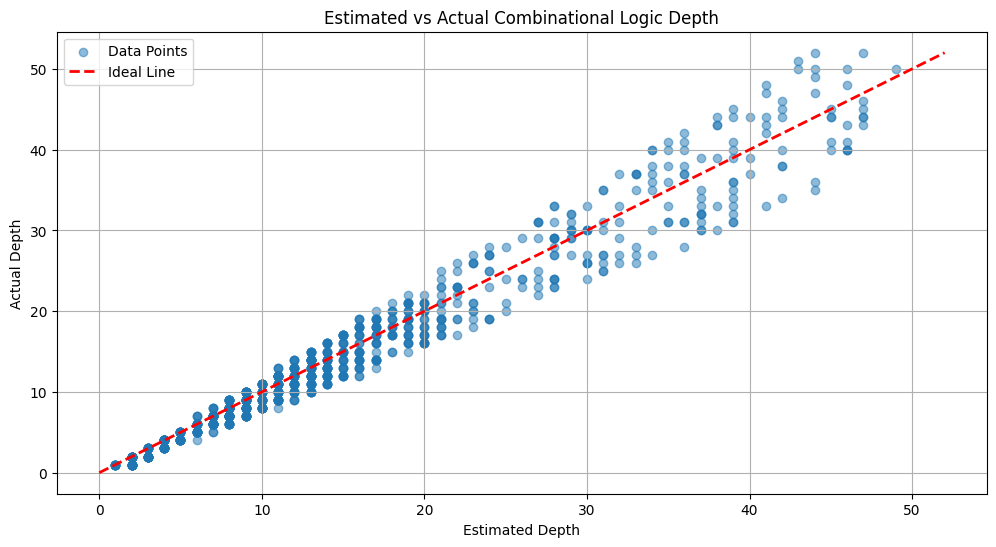

In [27]:
if __name__ == '__main__':
    generator = RTLDatasetGenerator()
    dataset = generator.generate_dataset(num_designs=1000, complexity_range=(1, 5))
    print("\nCorrelation between estimated and actual depth:")
    print(dataset["estimated_depth"].corr(dataset["actual_depth"]))
    print(dataset.to_string())
    print(dataset.head(10))
    print("\nDataset summary:")
    print(dataset.describe())

    plt.figure(figsize=(12, 6))
    plt.scatter(dataset['estimated_depth'], dataset['actual_depth'], alpha=0.5, label='Data Points')
    plt.plot([0, max(dataset['estimated_depth'].max(), dataset['actual_depth'].max())], 
             [0, max(dataset['estimated_depth'].max(), dataset['actual_depth'].max())], 
             'r--', lw=2, label='Ideal Line')
    plt.xlabel('Estimated Depth')
    plt.ylabel('Actual Depth')
    plt.title('Estimated vs Actual Combinational Logic Depth')
    plt.legend()
    plt.grid(True)
    plt.show()

Random Forest Results:
Mean Squared Error: 0.4584149999999999
R-squared Score: 0.9628542315335701


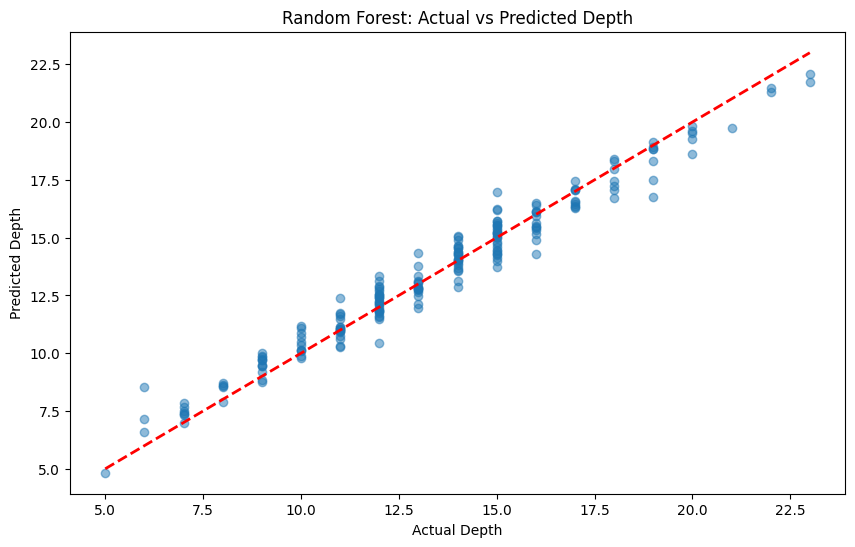

Linear Regression Results:
Mean Squared Error: 0.08446559113436489
R-squared Score: 0.9931556792608068


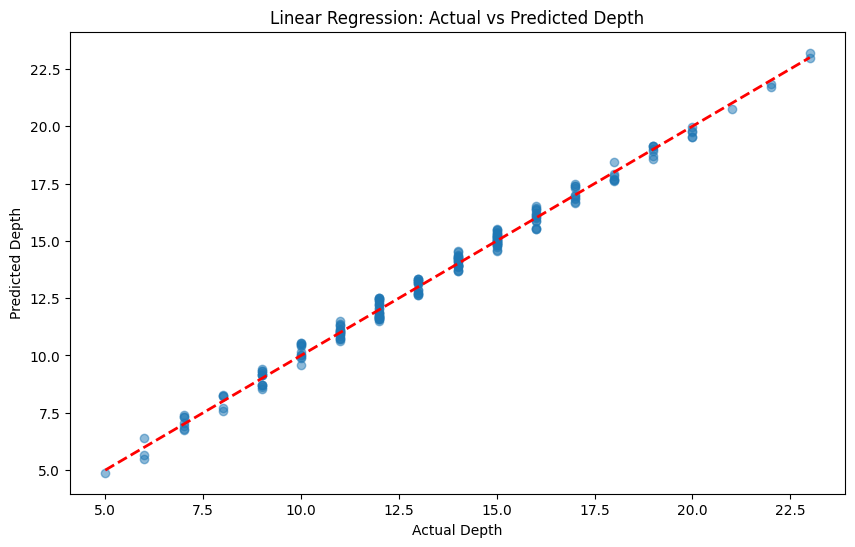

Support Vector Regression Results:
Mean Squared Error: 0.3051059124622619
R-squared Score: 0.9752770010098666


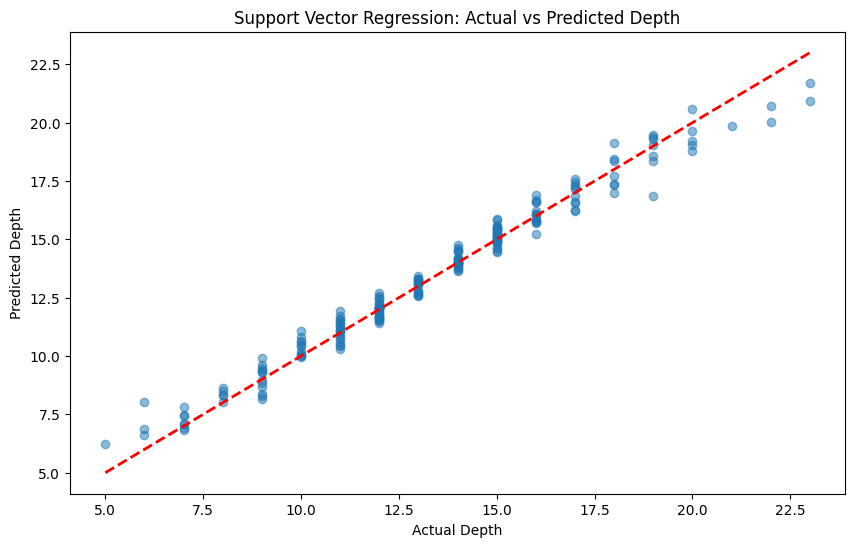

Gradient Boosting Results:
Mean Squared Error: 0.2440575880459875
R-squared Score: 0.980223800141724


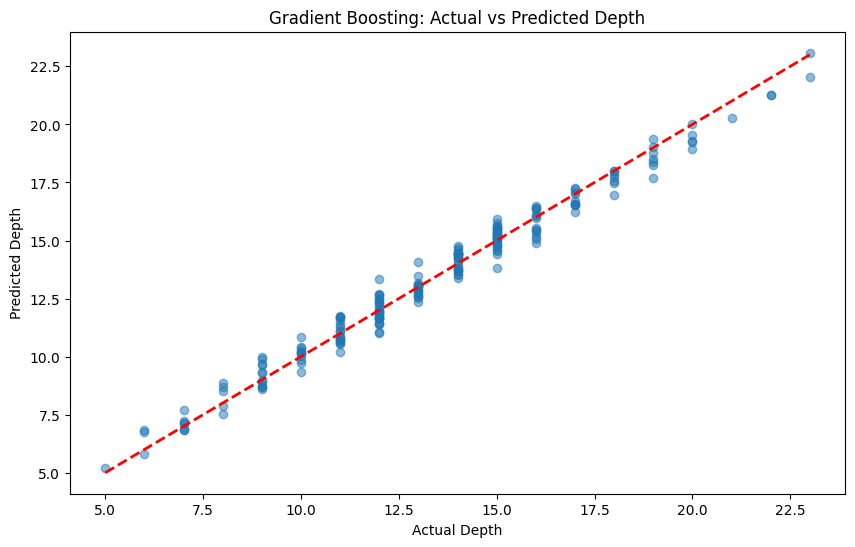

XGBoost Results:
Mean Squared Error: 0.34660457637258446
R-squared Score: 0.9719143509864807


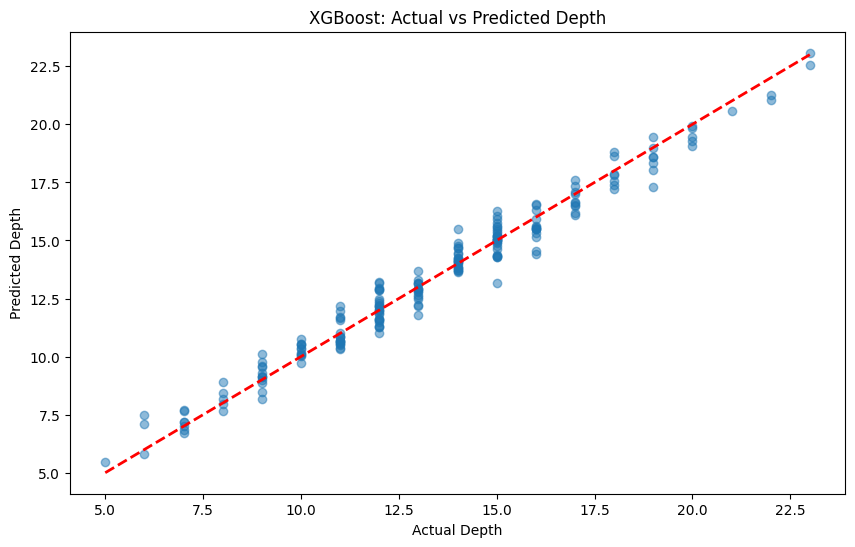

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Neural Network Results:
Mean Squared Error: 0.12007581305444319
R-squared Score: 0.9902701377868652

Model Comparison:
Random Forest: MSE = 0.4584, R2 = 0.9629
Linear Regression: MSE = 0.0845, R2 = 0.9932
Support Vector Regression: MSE = 0.3051, R2 = 0.9753
Gradient Boosting: MSE = 0.2441, R2 = 0.9802
XGBoost: MSE = 0.3466, R2 = 0.9719
Neural Network: MSE = 0.1201, R2 = 0.9903

Best Model: Linear Regression
MSE: 0.0845
R2: 0.9932


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_csv('rtl_dataset.csv')

# Prepare features and target
X = dataset[['fan_in', 'fan_out', 'num_gates', 'path_length', 'conditional_statements', 'parallel_ops']]
y = dataset['combinational_depth']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and plot results
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Results:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Depth')
    plt.ylabel('Predicted Depth')
    plt.title(f'{model_name}: Actual vs Predicted Depth')
    plt.show()
    
    return mse, r2

# Dictionary to store results
results = {}

# 1. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mse, rf_r2 = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")
results["Random Forest"] = {"MSE": rf_mse, "R2": rf_r2}

# 2. Linear Regression
lr_model = LinearRegression()
lr_mse, lr_r2 = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")
results["Linear Regression"] = {"MSE": lr_mse, "R2": lr_r2}

# 3. Support Vector Regression
svr_model = SVR(kernel='rbf')
svr_mse, svr_r2 = evaluate_model(svr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Support Vector Regression")
results["Support Vector Regression"] = {"MSE": svr_mse, "R2": svr_r2}

# 4. Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_mse, gb_r2 = evaluate_model(gb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting")
results["Gradient Boosting"] = {"MSE": gb_mse, "R2": gb_r2}

# 5. XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_mse, xgb_r2 = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost")
results["XGBoost"] = {"MSE": xgb_mse, "R2": xgb_r2}

# 6. Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)
nn_pred = nn_model.predict(X_test_scaled).flatten()
nn_mse = mean_squared_error(y_test, nn_pred)
nn_r2 = r2_score(y_test, nn_pred)
results["Neural Network"] = {"MSE": nn_mse, "R2": nn_r2}

print("\nNeural Network Results:")
print(f"Mean Squared Error: {nn_mse}")
print(f"R-squared Score: {nn_r2}")

# Compare all models
print("\nModel Comparison:")
for model, metrics in results.items():
    print(f"{model}: MSE = {metrics['MSE']:.4f}, R2 = {metrics['R2']:.4f}")

# Find the best model
best_model = min(results, key=lambda x: results[x]['MSE'])
print(f"\nBest Model: {best_model}")
print(f"MSE: {results[best_model]['MSE']:.4f}")
print(f"R2: {results[best_model]['R2']:.4f}")